<a href="https://colab.research.google.com/github/ParitKansal/Pytorch/blob/main/ANN_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Required PyTorch Modules

In [35]:
!pip install torchinfo

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import torch.nn as nn

## 2. Downloading and Preparing the FashionMNIST Dataset

In [31]:
# Download and load the training data for the FashionMNIST dataset.
# - 'root': Directory where the data will be stored.
# - 'train': Specifies whether to download the training set (True).
# - 'download': Downloads the dataset if it isn't already downloaded.
# - 'transform': Applies a transformation to the data (e.g., converting images to tensors).
training_data = datasets.FashionMNIST(
    root="data",       # Path to save the dataset.
    train=True,        # Load the training data.
    download=True,     # Download the dataset if not already present.
    transform=ToTensor(),  # Transform images to PyTorch tensors.
)

# Download and load the test data for the FashionMNIST dataset.
# - Similar to the training data, but 'train' is set to False to download the test set.
test_data = datasets.FashionMNIST(
    root="data",       # Path to save the dataset.
    train=False,       # Load the test data.
    download=True,     # Download the dataset if not already present.
    transform=ToTensor(),  # Transform images to PyTorch tensors.
)

In [32]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 3. Setting Up the Device for Model Trainin

In [33]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## 4. Defining and Initializing the Neural Network Model

In [34]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer to flatten input images from (28, 28) to (28*28)
        self.flatten = nn.Flatten()

        # Sequential model consisting of Linear layers followed by Batch Normalization, Dropout, and ReLU activations
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512, bias=True),  # Fully connected layer: input size (28*28), output size 512
            nn.BatchNorm1d(512),               # Batch Normalization
            nn.ReLU(),                         # Activation function: ReLU
            nn.Dropout(0.2),                   # Dropout with 20% probability
            nn.Linear(512, 256, bias=True),    # Fully connected layer: input size 512, output size 256
            nn.BatchNorm1d(256),               # Batch Normalization
            nn.ReLU(),                         # Activation function: ReLU
            nn.Dropout(0.2),                   # Dropout with 20% probability
            nn.Linear(256, 10, bias=True)      # Fully connected layer: input size 256, output size 10 (class scores)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.flatten(x)                   # Flatten the input
        logits = self.linear_relu_stack(x)    # Pass through the linear, BatchNorm, ReLU, and Dropout layers
        return logits                         # Return the raw scores (logits) for each class

# Specify the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the specified device
model = NeuralNetwork().to(device)

# Print the model's architecture
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [36]:
from torchinfo import summary

summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 10]                  --
├─Flatten: 1-1                           [64, 784]                 --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-1                       [64, 512]                 401,920
│    └─BatchNorm1d: 2-2                  [64, 512]                 1,024
│    └─ReLU: 2-3                         [64, 512]                 --
│    └─Dropout: 2-4                      [64, 512]                 --
│    └─Linear: 2-5                       [64, 256]                 131,328
│    └─BatchNorm1d: 2-6                  [64, 256]                 512
│    └─ReLU: 2-7                         [64, 256]                 --
│    └─Dropout: 2-8                      [64, 256]                 --
│    └─Linear: 2-9                       [64, 10]                  2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params

## 5. Defining the Loss Function and Optimizer

### 5.1. Selecting the Loss Function

In [37]:
# Define the loss function
# - nn.CrossEntropyLoss() computes the cross-entropy loss between the predicted logits and true labels.
# - It combines nn.LogSoftmax() and nn.NLLLoss() in a single step.
# - This is commonly used for multi-class classification tasks.
loss_fn = nn.CrossEntropyLoss()

### 5.2. Choosing the Optimizer

In [38]:
# Define the optimizer
# - torch.optim.SGD: Implements stochastic gradient descent (SGD) optimization.
# - 'model.parameters()': Passes the parameters of the model to the optimizer for updates.
# - 'lr=1e-3': Sets the learning rate to 0.001 for gradient updates.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 6. Model Training and Testing

In [39]:
# Lists to store accuracy and loss values for training and testing
train_accuracies = []  # Store training accuracy for each epoch
test_accuracies = []   # Store test accuracy for each epoch
train_losses = []      # Store training loss for each epoch
test_losses = []       # Store test loss for each epoch

### 6.1. Defining the Training Function

In [40]:
# Define the training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # Total number of samples in the training dataset
    model.train()  # Set the model to training mode

    correct = 0  # Counter for correct predictions (used to calculate accuracy)
    train_loss = 0  # Accumulator for cumulative loss over the epoch

    # Iterate over batches in the dataloader
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move data and labels to the specified device

        # Forward pass: Compute predictions and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation and optimization
        loss.backward()        # Compute gradients
        optimizer.step()        # Update model parameters
        optimizer.zero_grad()   # Reset gradients for the next batch

        # Accumulate loss and correct predictions for the batch
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Print progress every 100 batches
        if batch % 100 == 0:
            loss_value = loss.item()  # Current batch loss
            current = (batch + 1) * len(X)  # Number of samples processed so far
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(dataloader)  # Average loss over all batches
    accuracy = 100 * correct / size  # Accuracy as a percentage
    train_losses.append(avg_loss)  # Append the average training loss to the list
    train_accuracies.append(accuracy)  # Append the training accuracy to the list

    # Print test results for the current epoch
    print(f"\nTrain Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {avg_loss:>8f} \n")

### 6.2. Defining the Testing Function

In [41]:
# Define the testing function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)  # Total number of samples in the test dataset
    num_batches = len(dataloader)  # Total number of batches in the test dataloader
    model.eval()  # Set the model to evaluation mode

    test_loss, correct = 0, 0  # Initialize accumulators for loss and correct predictions

    with torch.no_grad():  # Disable gradient computation for evaluation
        # Iterate over batches in the test dataloader
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move data and labels to the specified device
            pred = model(X)  # Forward pass to compute predictions
            test_loss += loss_fn(pred, y).item()  # Accumulate batch loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # Count correct predictions

    # Calculate average loss and accuracy for the test dataset
    avg_loss = test_loss / num_batches  # Average loss over all test batches
    accuracy = 100 * correct / size  # Accuracy as a percentage
    test_losses.append(avg_loss)  # Append the average test loss to the list
    test_accuracies.append(accuracy)  # Append the test accuracy to the list

    # Print test results for the current epoch
    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {avg_loss:>8f} \n")

### 6.3. Training Loop and Model Evaluation

In [42]:
# Training loop
epochs = 50  # Number of epochs to train the model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)  # Train the model on the training dataset
    test(test_dataloader, model, loss_fn)  # Evaluate the model on the test dataset

print("Done!")  # Print when training is complete

Epoch 1
-------------------------------
loss: 2.324656  [   64/60000]
loss: 1.734075  [ 6464/60000]
loss: 1.168415  [12864/60000]
loss: 1.375338  [19264/60000]
loss: 1.116978  [25664/60000]
loss: 1.050923  [32064/60000]
loss: 0.964270  [38464/60000]
loss: 0.891343  [44864/60000]
loss: 0.932602  [51264/60000]
loss: 0.934667  [57664/60000]

Train Error: 
 Accuracy: 66.8%, Avg loss: 1.165813 

Test Error: 
 Accuracy: 75.9%, Avg loss: 0.797519 

Epoch 2
-------------------------------
loss: 0.819543  [   64/60000]
loss: 0.839328  [ 6464/60000]
loss: 0.613247  [12864/60000]
loss: 0.913108  [19264/60000]
loss: 0.796832  [25664/60000]
loss: 0.755571  [32064/60000]
loss: 0.764416  [38464/60000]
loss: 0.754915  [44864/60000]
loss: 0.760291  [51264/60000]
loss: 0.800918  [57664/60000]

Train Error: 
 Accuracy: 76.5%, Avg loss: 0.748707 

Test Error: 
 Accuracy: 78.6%, Avg loss: 0.646862 

Epoch 3
-------------------------------
loss: 0.640108  [   64/60000]
loss: 0.711539  [ 6464/60000]
loss: 0.

### 6.4. Visualizing Training and Test Performance

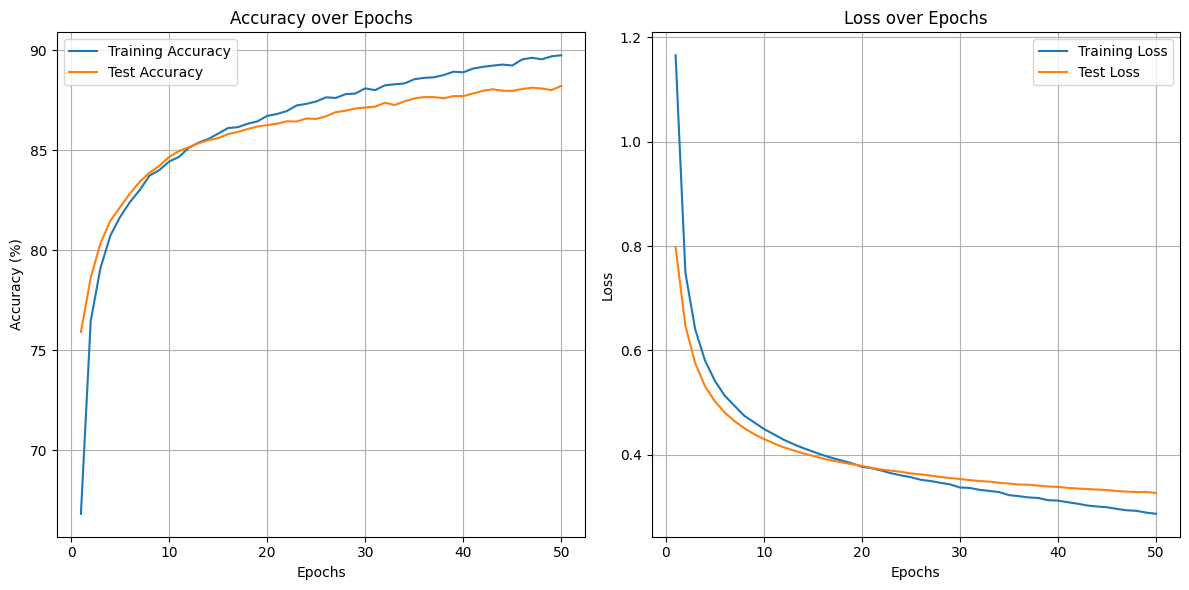

In [43]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs_range = range(1, len(train_accuracies) + 1)

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot Training and Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot Training and Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## 7. Model Saving and Loading

### 7.1. Model Saving

In [44]:
torch.save(model.state_dict(), "model1.pth")
print("Saved PyTorch Model State to model1.pth")

Saved PyTorch Model State to model1.pth


### 7.2. Model Saving Loading

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer to flatten input images from (28, 28) to (28*28)
        self.flatten = nn.Flatten()

        # Sequential model consisting of Linear layers followed by Batch Normalization, Dropout, and ReLU activations
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512, bias=True),  # Fully connected layer: input size (28*28), output size 512
            nn.BatchNorm1d(512),               # Batch Normalization
            nn.ReLU(),                         # Activation function: ReLU
            nn.Dropout(0.2),                   # Dropout with 20% probability
            nn.Linear(512, 256, bias=True),    # Fully connected layer: input size 512, output size 256
            nn.BatchNorm1d(256),               # Batch Normalization
            nn.ReLU(),                         # Activation function: ReLU
            nn.Dropout(0.2),                   # Dropout with 20% probability
            nn.Linear(256, 10, bias=True)      # Fully connected layer: input size 256, output size 10 (class scores)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.flatten(x)                   # Flatten the input
        logits = self.linear_relu_stack(x)    # Pass through the linear, BatchNorm, ReLU, and Dropout layers
        return logits                         # Return the raw scores (logits) for each class

# Specify the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the specified device
model = NeuralNetwork().to(device)

# Print the model's architecture
print(model)

model.load_state_dict(torch.load("model1.pth", weights_only=True))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)


<All keys matched successfully>

torch.Size([1, 28, 28])
Predicted: "Ankle boot", Actual: "Ankle boot"


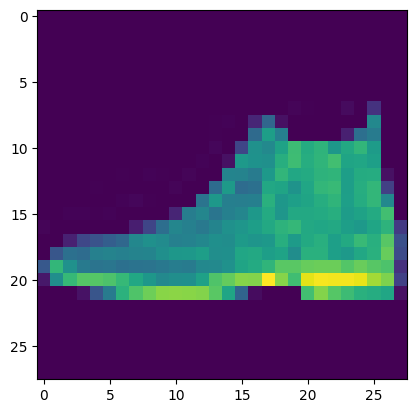

In [47]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    print(x.shape)
    x = x.to(device)
    pred = model(x)
    plt.imshow(x.squeeze())
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')